In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import time

In [2]:
#Variables
image_size = 256
in_channel_spec = 9
in_channel_tool = 3
num_classes = 3
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 10

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

Using cuda


In [4]:
# DatasetCreator for combined spec and tool data
class DatasetCreator(Dataset):
    def __init__(self, spec_path, labels_path, image_size, channels):
        # Read the Labels file as a dataframe and store the paths to specX,Y,Z and tool in the same dataframe.
        # Don't load the images now, requires lot of memory.
        # Load in __getitem__()
        self.df = pd.read_csv(labels_path, index_col=0)
        self.df['specX'] = self.df.index.map(lambda id: f'{spec_path}/specX/{id}.png')
        self.df['specY'] = self.df.index.map(lambda id: f'{spec_path}/specY/{id}.png')
        self.df['specZ'] = self.df.index.map(lambda id: f'{spec_path}/specZ/{id}.png')
        self.df['tool'] = self.df.index.map(lambda id: f'{spec_path}/tool/{id}.jpg')
        self.image_size = image_size
        self.channels = channels

    def __get_df__(self):
        # Just for debugging purpose
        return self.df

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        # place holder for all the three images (each image has 3 channels)
        image = torch.zeros((self.image_size, self.image_size, self.channels))

        # idx_details has every think we need about the entry of that idx
        idx_details = self.df.iloc[idx]

        # Read images
        # Note that we are not converting BGR to RGB because it doesn't matter to the NN
        img_x = cv2.imread(idx_details['specX'])
        res_x = cv2.resize(img_x, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        img_y = cv2.imread(idx_details['specY'])
        res_y = cv2.resize(img_y, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        img_z = cv2.imread(idx_details['specZ'])
        res_z = cv2.resize(img_z, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        img_tool = cv2.imread(idx_details['tool'])
        res_tool = cv2.resize(img_tool, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        image = torch.cat((torch.tensor(res_x), torch.tensor(res_y), torch.tensor(res_z), torch.tensor(res_tool)), dim=2).float()

        label = idx_details['tool_label']

        # change image to CxHxW from HxWxC
        return image.transpose(0, 2).transpose(1, 2), label -1

In [5]:
data_path = "./dataset_aug"
labels_path = "./labels_aug/random_distribution"

train_dataset = DatasetCreator(data_path, os.path.join(labels_path, "train.csv"), image_size, 3)
test_dataset = DatasetCreator(data_path, os.path.join(labels_path, "test.csv"), image_size, 3)
val_dataset = DatasetCreator(data_path, os.path.join(labels_path, "val.csv"), image_size, 3)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [6]:
print(len(train_dataset), len(test_dataset), len(val_dataset))

2460 48 54


In [7]:
imgs, labels = next(iter(train_dataloader))
print(imgs.shape, labels.shape)

torch.Size([64, 12, 256, 256]) torch.Size([64])


In [8]:
df_train = train_dataset.__get_df__()
df_train.head()

,image_label,tool_label,specX,specY,specZ,tool
id,,,,,,
T6R1B4,sharp,1,./dataset_aug/specX/T6R1B4.png,./dataset_aug/specY/T6R1B4.png,./dataset_aug/specZ/T6R1B4.png,./dataset_aug/tool/T6R1B4.jpg
T2R3B2,sharp,1,./dataset_aug/specX/T2R3B2.png,./dataset_aug/specY/T2R3B2.png,./dataset_aug/specZ/T2R3B2.png,./dataset_aug/tool/T2R3B2.jpg
T9R11B1,used,2,./dataset_aug/specX/T9R11B1.png,./dataset_aug/specY/T9R11B1.png,./dataset_aug/specZ/T9R11B1.png,./dataset_aug/tool/T9R11B1.jpg
T9R3B1,sharp,1,./dataset_aug/specX/T9R3B1.png,./dataset_aug/specY/T9R3B1.png,./dataset_aug/specZ/T9R3B1.png,./dataset_aug/tool/T9R3B1.jpg
T6R2B4,sharp,1,./dataset_aug/specX/T6R2B4.png,./dataset_aug/specY/T6R2B4.png,./dataset_aug/specZ/T6R2B4.png,./dataset_aug/tool/T6R2B4.jpg


In [9]:
#TODO: import model definition from other ipynb files

kernel = (3,3)
patch = 32
filters = 128
depth = 4
padding = (1,1)

class DepthWiseConvolutionBlock(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.dconv = nn.Conv2d(in_channels=filters, out_channels=filters, kernel_size=kernel, stride=1, padding=padding, groups=filters)
        self.activation1 = nn.GELU()
        self.bn1 = nn.BatchNorm2d(num_features=filters)
        self.pconv = nn.Conv2d(in_channels=filters, out_channels=filters, kernel_size=1)
        self.activation2 = nn.GELU()
        self.bn2 = nn.BatchNorm2d(num_features=filters)

    def forward(self, x):
        x0 = x
        _ = self.dconv(x)
        _ = x0 + self.bn1(self.activation1(_))
        _ = self.pconv(_)
        return self.bn2(self.activation2(_))
    
class BaseBlock(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv = nn.Conv2d(in_channels=in_channel_spec, out_channels=filters, stride=patch, kernel_size=patch, padding=0)
        self.activation = nn.GELU()
        self.bn = nn.BatchNorm2d(num_features=filters)

    def forward(self, x):
        _ = self.conv(x)
        _ = self.activation(_)
        return self.bn(_)
    
# class ClassificationBlock(nn.Module):
#     def __init__(self, *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)

#         self.pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
#         self.linear = nn.Linear(in_features=filters, out_features=num_classes)

#     def forward(self, x):
#         # print(x.shape)
#         _ = self.pool(x)
#         # print(f"After Avg Pooling: {_.shape}")
#         _ = _.view(x.shape[0], -1)
#         return self.linear(_)
    
class SpectogramModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.model = None
        layers = [BaseBlock()]
        for i in range(depth):
            layers.append(DepthWiseConvolutionBlock())
        self.model = nn.Sequential(*layers)
        # CLassification
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.linear = nn.Linear(in_features=filters, out_features=num_classes)


    def forward(self, x):
        _ = self.model(x)
        _ = self.pool(_)
        _ = _.view(x.shape[0], -1)
        return self.linear(_)
    
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=3, cnn_out_channels=64):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, cnn_out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(cnn_out_channels)
        self.conv2 = nn.Conv2d(cnn_out_channels, cnn_out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(cnn_out_channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(cnn_out_channels * (image_size // 4) ** 2, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# Path to the models
model_path = 'models'

# Load the models
model_spec = SpectogramModel()
model_spec.load_state_dict(torch.load(f"{model_path}/model_d4.pth"))
model_spec = model_spec.to(device)

model_tool = SimpleCNN()
model_tool.load_state_dict(torch.load(f"{model_path}/tool_model.pth"))
model_tool = model_tool.to(device)

# Freeze the models
for param in model_spec.parameters():
    param.requires_grad = False

for param in model_tool.parameters():
    param.requires_grad = False

# Verify that the parameters are frozen
print("Model Tool Parameters:")
for name, param in model_tool.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

print("\nModel Spec Parameters:")
for name, param in model_spec.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

Model Tool Parameters:
conv1.weight: requires_grad=False
conv1.bias: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
conv2.weight: requires_grad=False
conv2.bias: requires_grad=False
bn2.weight: requires_grad=False
bn2.bias: requires_grad=False
fc1.weight: requires_grad=False
fc1.bias: requires_grad=False
fc2.weight: requires_grad=False
fc2.bias: requires_grad=False

Model Spec Parameters:
model.0.conv.weight: requires_grad=False
model.0.conv.bias: requires_grad=False
model.0.bn.weight: requires_grad=False
model.0.bn.bias: requires_grad=False
model.1.dconv.weight: requires_grad=False
model.1.dconv.bias: requires_grad=False
model.1.bn1.weight: requires_grad=False
model.1.bn1.bias: requires_grad=False
model.1.pconv.weight: requires_grad=False
model.1.pconv.bias: requires_grad=False
model.1.bn2.weight: requires_grad=False
model.1.bn2.bias: requires_grad=False
model.2.dconv.weight: requires_grad=False
model.2.dconv.bias: requires_grad=False
model.2.bn1.wei

In [11]:
model_spec

SpectogramModel(
  (model): Sequential(
    (0): BaseBlock(
      (conv): Conv2d(9, 128, kernel_size=(32, 32), stride=(32, 32))
      (activation): GELU(approximate='none')
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DepthWiseConvolutionBlock(
      (dconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (activation1): GELU(approximate='none')
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pconv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (activation2): GELU(approximate='none')
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): DepthWiseConvolutionBlock(
      (dconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (activation1): GELU(approximate='none')
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

In [12]:
# Sanity Test Spec Model
loss_func = nn.CrossEntropyLoss()
x = torch.zeros((64, 9, 256, 256)).to(device)
y = torch.randint(0, 3, (64, )).to(device)
y_pred = model_spec(x)
loss = loss_func(y_pred, y)
# loss.backward() # comented since model weights are frozen, uncommenting should give error

print(loss)
print(y, y_pred)

tensor(1.1079, device='cuda:0')
tensor([1, 0, 1, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 0, 0, 1, 1, 2,
        2, 2, 0, 1, 2, 2, 1, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2,
        0, 2, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1], device='cuda:0') tensor([[ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1489],
        [ 0.0318,  0.1604, -0.1

In [13]:
model_tool

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [14]:
# Sanity Test Tool Model
loss_func = nn.CrossEntropyLoss()
x = torch.zeros((64, 3, 256, 256)).to(device)
y = torch.randint(0, 1, (64, )).to(device)
y_pred = model_tool(x)
loss = loss_func(y_pred, y)
# loss.backward() # comented since model weights are frozen, uncommenting should give error

print(loss)
print(y, y_pred)

tensor(0.1498, device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([[ 3.1653,  1.1233, -0.9634],
        [ 3.5217,  1.1784, -1.0462],
        [ 3.1210,  1.0362, -0.8305],
        [ 2.4183,  0.9249, -0.6793],
        [ 2.8012,  1.4006, -1.2274],
        [ 2.9382,  0.8488, -0.6963],
        [ 3.0744,  1.0800, -0.9233],
        [ 3.1113,  0.7690, -0.6199],
        [ 2.7083,  1.2172, -1.0807],
        [ 3.1402,  1.0760, -0.9172],
        [ 2.9381,  1.0565, -0.9146],
        [ 2.8738,  1.0775, -0.9073],
        [ 3.0264,  1.0947, -0.9747],
        [ 3.1752,  1.0499, -0.8571],
        [ 3.2311,  0.6781, -0.5510],
        [ 3.5312,  1.1444, -1.0046],
        [ 3.0633,  0.7790, -0.6426],
        [ 3.1425,  0.7531, -0.5978],
        [ 3.0175,  1.3468, -1.1257],
        [ 2.9297,  1.0591, -0.9

In [26]:
# Multi Modal Model Definition
class MultimodalConvModel(nn.Module):
    def __init__(self, model_tool, model_spec, num_classes):
        super(MultimodalConvModel, self).__init__()

        # Truncate the tool model
        self.truncated_model_tool = nn.Sequential(*list(model_tool.children())[:-3]).to(device)

        # truncate the spec model
        # self.truncated_model_spec = nn.Sequential(*list(*list(model_spec.children()))[:-1]).to(device)

        self.truncated_model_spec = nn.Sequential(*list(model_spec.children())[:-1]).to(device)

        # TODO: get flattened models with correct output shapes from both models directly, instead of this hack
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        print(self.truncated_model_tool)
        print(self.truncated_model_spec)

        # Verify that the parameters are frozen
        print("Model Tool Parameters:")
        for name, param in self.truncated_model_tool.named_parameters():
            print(f"{name}: requires_grad={param.requires_grad}")

        print("\nModel Spec Parameters:")
        for name, param in self.truncated_model_spec.named_parameters():
            print(f"{name}: requires_grad={param.requires_grad}")
       

        # Get the input shapes of the models
        tool_input_shape = list(model_tool.children())[0].weight.shape
        print(tool_input_shape)

        spec_input_shape = list(list(model_spec.children())[0][0].children())[0].weight.shape
        print(spec_input_shape)

        # Get the output shapes of the models
        tool_output_dim = self.truncated_model_tool(torch.zeros(*tool_input_shape).to(device)).shape[1]
        print(tool_output_dim)

        spec_output_dim = self.truncated_model_spec(torch.zeros(*spec_input_shape).to(device)).shape[1]
        print(spec_output_dim)

        # GRU and classification layer
        self.gru = nn.GRU(tool_output_dim + spec_output_dim, 256, dropout=0.1, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x1, x2):
        tool_output = self.truncated_model_tool(x2)
        spec_output = self.truncated_model_spec(x1)
        # spec_output = self.pool(spec_output)
        tool_output = self.pool(tool_output)
        # print(tool_output.shape)
        # print(spec_output.shape)
        merged_output = torch.cat([tool_output, spec_output], dim=1)
        # print(merged_output.shape)
        merged_output = merged_output.view(merged_output.size(0), merged_output.size(1))
        # print(merged_output.shape)
        gru_output, _ = self.gru(merged_output)
        output = self.fc(gru_output)
        return output

In [27]:
#init model, loss function, optimizer
model = MultimodalConvModel(model_tool, model_spec, num_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Sequential(
    (0): BaseBlock(
      (conv): Conv2d(9, 128, kernel_size=(32, 32), stride=(32, 32))
      (activation): GELU(approximate='none')
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DepthWiseConvolutionBlock(
      (dconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (activation1): GELU(approximate='none')
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pconv): Conv2d(128, 128, kernel_size=(1, 1),

/opt/conda/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [28]:
model

MultimodalConvModel(
  (truncated_model_tool): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (truncated_model_spec): Sequential(
    (0): Sequential(
      (0): BaseBlock(
        (conv): Conv2d(9, 128, kernel_size=(32, 32), stride=(32, 32))
        (activation): GELU(approximate='none')
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): DepthWiseConvolutionBlock(
        (dconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
        (activation1): GELU(approximate='none')
        (bn1): BatchNorm2d(128, eps=1e-05,

In [29]:
#train and eval functions
def train(model, dataloader, optimizer, loss_func, device):
    model.train()
    model = model.to(device)
    total_loss, total_count, acc_count = 0, 0, 0

    for idx, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # print(X.shape)
        # print(y.shape)

        # Split X into input_tool and input_spec
        input_spec = X[:, :in_channel_spec, ...]
        input_tool = X[:, in_channel_spec:in_channel_spec + in_channel_tool, ...]

        optimizer.zero_grad()
        y_pred = model(input_spec, input_tool)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimizer.step()

        # Loss
        total_loss += loss.item()
        total_count += X.size(0) # Batch size

        # Accuracy
        _, y_pred_class = y_pred.max(dim=1)
        acc_count += (y_pred_class == y).sum().item()

    return total_loss/total_count, acc_count/total_count

def evaluate(model, dataloader, loss_func, device):
    model.eval()
    model = model.to(device)
    total_loss, total_count, acc_count = 0, 0, 0

    with torch.no_grad():
        for idx, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            # Split X into input_tool and input_spec
            input_spec = X[:, :in_channel_spec, ...]
            input_tool = X[:, in_channel_spec:in_channel_spec + in_channel_tool, ...]

            y_pred = model(input_spec, input_tool)
            loss = loss_func(y_pred, y)

            total_loss += loss.item()
            total_count += X.size(0)

            # Accuracy
            _, y_pred_class = y_pred.max(dim=1)
            acc_count += (y_pred_class == y).sum().item()

    return total_loss/total_count, acc_count/total_count

In [30]:
#training loop
train_loss_epochs = []
val_loss_epochs = []
train_acc_epochs = []
val_acc_epochs = []

for epoch in range(num_epochs):
    start = time.time()
    print("started new epoch ..")
    loss_train, train_acc = train(model, train_dataloader, optimizer, loss_func, device)
    loss_val, val_acc = evaluate(model, val_dataloader, loss_func, device)

    train_loss_epochs.append(loss_train)
    val_loss_epochs.append(loss_val)
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)
    end = time.time()

    print("=" * 102)
    print(f"| Epoch {epoch+1}/{num_epochs} | time: {(end-start):.3f} | Train Loss: {loss_train:.3f} | Val Loss: {loss_val:.3f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} |")


started new epoch ..
| Epoch 1/10 | time: 126.968 | Train Loss: 0.003 | Val Loss: 0.004 | Train Acc: 0.944 | Val Acc: 0.907 |
started new epoch ..
| Epoch 2/10 | time: 112.207 | Train Loss: 0.001 | Val Loss: 0.005 | Train Acc: 0.980 | Val Acc: 0.944 |
started new epoch ..
| Epoch 3/10 | time: 116.302 | Train Loss: 0.001 | Val Loss: 0.004 | Train Acc: 0.986 | Val Acc: 0.926 |
started new epoch ..
| Epoch 4/10 | time: 114.798 | Train Loss: 0.000 | Val Loss: 0.004 | Train Acc: 0.993 | Val Acc: 0.926 |
started new epoch ..
| Epoch 5/10 | time: 116.895 | Train Loss: 0.000 | Val Loss: 0.004 | Train Acc: 0.997 | Val Acc: 0.926 |
started new epoch ..
| Epoch 6/10 | time: 128.697 | Train Loss: 0.000 | Val Loss: 0.004 | Train Acc: 1.000 | Val Acc: 0.926 |
started new epoch ..
| Epoch 7/10 | time: 118.361 | Train Loss: 0.000 | Val Loss: 0.004 | Train Acc: 1.000 | Val Acc: 0.926 |
started new epoch ..
| Epoch 8/10 | time: 167.338 | Train Loss: 0.000 | Val Loss: 0.004 | Train Acc: 1.000 | Val Acc: 

In [31]:
test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.9791666666666666


In [32]:
#save loss and accuracy
torch.save(model.state_dict(), "models/rnn_model")
torch.save(train_loss_epochs, "output/train_loss_epochs.pt")
torch.save(val_loss_epochs, "output/val_loss_epochs.pt")
torch.save(train_acc_epochs, "output/train_acc_epochs.pt")
torch.save(val_acc_epochs, "output/val_acc_epochs.pt")

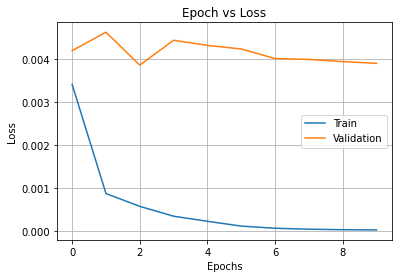

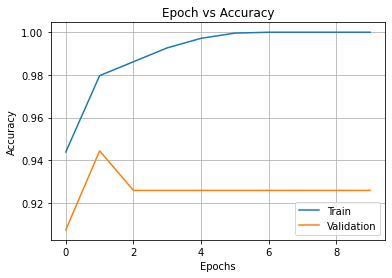

In [33]:
#plot Epoch vs. Loss
plt.plot(train_loss_epochs, label="Train")
plt.plot(val_loss_epochs, label="Validation")
plt.title("Epoch vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#plot Epoch vs. Accuracy
plt.plot(train_acc_epochs, label="Train")
plt.plot(val_acc_epochs, label="Validation")
plt.title("Epoch vs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()